# Training in Brax

In [Brax Basics](https://colab.research.google.com/github/google/brax/blob/main/notebooks/basics.ipynb) we learned about the core components of Brax: static system definitions, dynamic state, and dynamic input.  With these core components, we can optimize a function of the Brax simulation to learn all kinds of fun and useful behaviors in a physical environment.

Brax provides a [gym](https://gym.openai.com/)-like environment for training policies.  Brax comes with PPO, SAC, evolutionary search, and trajectory optimization algorithms out of the box.  Let's try it out!

In [1]:
#@title Colab setup and imports
#@markdown ## ⚠️ PLEASE NOTE:
#@markdown This colab runs best using a TPU runtime.  From the Colab menu, choose Runtime > Change Runtime Type, then select **'TPU'** in the dropdown.

from datetime import datetime
import functools
import os

from IPython.display import HTML, clear_output

# Need jax>=0.2.21 for this colab to work.
# TODO: Remove this after colab bumps their jax version.
import sys
if 'jax' not in sys.modules:
  !pip install -U jax
  clear_output()

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

try:
  import brax
except ImportError:
  !pip install git+https://github.com/google/brax.git@main
  clear_output()
  import brax

from brax import envs
from brax.training import ppo, sac
from brax.io import html

if 'COLAB_TPU_ADDR' in os.environ:
  from jax.tools import colab_tpu
  colab_tpu.setup_tpu()

In [Brax Basics](https://colab.research.google.com/github/google/brax/blob/main/notebooks/basics.ipynb) we explored simple systems with a couple of bodies and two joints.  Most practical systems have many more bodies, joints, and actuators.  Larger systems are tedious to author by hand, so Brax comes with a few built-in systems that are useful for quick experiments:

**[ant](https://github.com/google/brax/blob/main/brax/envs/ant.py)** from [OpenAI Gym Ant-v2](https://gym.openai.com/envs/Ant-v2/): make a four-legged creature walk forward as fast as possible

**[humanoid](https://github.com/google/brax/blob/main/brax/envs/humanoid.py)** from [OpenAI Gym Humanoid-v2](https://gym.openai.com/envs/Humanoid-v2/): make a three-dimensional bipedal robot walk forward as fast as possible, without falling over.

**[halfcheetah](https://github.com/google/brax/blob/main/brax/envs/halfcheetah.py)** from [OpenAI Gym HalfCheetah-v2](https://gym.openai.com/envs/HalfCheetah-v2/): make a two-dimensional two-legged creature walk forward as fast as possible

**[fetch](https://github.com/google/brax/blob/main/brax/envs/fetch.py)**: make a three-dimensional dog chase after a moving target.

**[grasp](https://github.com/google/brax/blob/main/brax/envs/grasp.py)**: a grabber hand must pick up a ball and carry it to a moving target.

**[ur5e](https://github.com/google/brax/blob/main/brax/envs/ur5e.py)**: a ur5e robot arm that moves its end effector to a series of targets.

**[reacher](https://github.com/google/brax/blob/main/brax/envs/reacher.py)**: from [OpenAI Gym Reacher-v2](https://gym.openai.com/envs/Reacher-v2/): makes a two-joint reacher arm move its tip to a target.

As systems get more complex, it becomes useful to have some way of visualizing them in 3D, to ensure you've defined your system the way you think you have.  Brax includes a little 3D viewer that makes it easy to quickly debug systems and trajectories:

In [2]:
#@title Visualizing pre-included Brax environments { run: "auto" }

env_name = "ant"  # @param ['ant', 'humanoid', 'fetch', 'grasp', 'halfcheetah', 'ur5e', 'reacher']
env_fn = envs.create_fn(env_name=env_name)
env = env_fn()
jit_env_reset = jax.jit(env.reset)
state = jit_env_reset(rng=jax.random.PRNGKey(seed=0))

def visualize(sys, qps):
  """Renders a 3D visualization of the environment."""
  return HTML(html.render(sys, qps))

visualize(env.sys, [state.qp])

# Training

Brax provides out of the box the following training algorithms:

* [Proximal policy optimization](https://github.com/google/brax/blob/main/brax/training/ppo.py)
* [Soft actor-critic](https://github.com/google/brax/blob/main/brax/training/sac.py)
* [Evolutionary strategy](https://github.com/google/brax/blob/main/brax/training/es.py)
* [Analytic policy gradients](https://github.com/google/brax/blob/main/brax/training/apg.py)

Trainers take as input an environment function and some hyperparameters, and return an inference function to operate the environment.

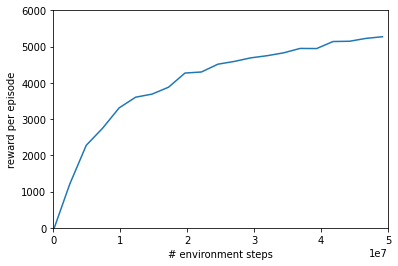

time to jit: 0:01:00.911316
time to train: 0:01:36.893174


In [3]:
#@title Training some pre-included Brax environments

# We determined some reasonable hyperparameters offline and share them here.
train_fn = {
  'ant': functools.partial(
      ppo.train, num_timesteps = 50000000, log_frequency = 20,
      reward_scaling = 10, episode_length = 1000, normalize_observations = True,
      action_repeat = 1, unroll_length = 5, num_minibatches = 32,
      num_update_epochs = 4, discounting = 0.95, learning_rate = 3e-4,
      entropy_cost = 1e-2, num_envs = 2048, batch_size = 1024
  ),
  'humanoid': functools.partial(
      sac.train, num_timesteps = 1048576 * 2.2,
      log_frequency = 131012, reward_scaling = 100, episode_length = 1000,
      normalize_observations = True, action_repeat = 1, discounting = 0.99,
      learning_rate = 4.5e-4, num_envs = 128, batch_size = 512,
      min_replay_size = 8192, max_replay_size = 1048576,
      grad_updates_per_step = 0.25, max_devices_per_host = 8
  ),
  'fetch': functools.partial(
      ppo.train, num_timesteps = 100_000_000, log_frequency = 20,
      reward_scaling = 5, episode_length = 1000, normalize_observations = True,
      action_repeat = 1, unroll_length = 20, num_minibatches = 32,
      num_update_epochs = 4, discounting = 0.997, learning_rate = 3e-4,
      entropy_cost = 0.001, num_envs = 2048, batch_size = 256
  ),
  'grasp': functools.partial(
      ppo.train, num_timesteps = 600_000_000, log_frequency = 10,
      reward_scaling = 10, episode_length = 1000, normalize_observations = True,
      action_repeat = 1, unroll_length = 20, num_minibatches = 32,
      num_update_epochs = 2, discounting = 0.99, learning_rate = 3e-4,
      entropy_cost = 0.001, num_envs = 2048, batch_size = 256
  ),
  'halfcheetah': functools.partial(
      ppo.train, num_timesteps = 100_000_000, log_frequency = 10,
      reward_scaling = 1, episode_length = 1000, normalize_observations = True,
      action_repeat = 1, unroll_length = 20, num_minibatches = 32,
      num_update_epochs = 8, discounting = 0.95, learning_rate = 3e-4,
      entropy_cost = 0.001, num_envs = 2048, batch_size = 512
  ),
  'ur5e': functools.partial(
      ppo.train, num_timesteps = 20_000_000, log_frequency = 20,
      reward_scaling = 10, episode_length = 1000, normalize_observations = True,
      action_repeat = 1, unroll_length = 5, num_minibatches = 32,
      num_update_epochs = 4, discounting = 0.95, learning_rate = 2e-4,
      entropy_cost = 1e-2, num_envs = 2048, batch_size = 1024,
      max_devices_per_host = 8
  ),
  'reacher': functools.partial(
      ppo.train, num_timesteps = 100_000_000, log_frequency = 20,
      reward_scaling = 5, episode_length = 1000, normalize_observations = True,
      action_repeat = 4, unroll_length = 50, num_minibatches = 32,
      num_update_epochs = 8, discounting = 0.95, learning_rate = 3e-4,
      entropy_cost = 1e-3, num_envs = 2048, batch_size = 256,
      max_devices_per_host = 8, seed = 1),
}[env_name]
max_y = {'ant': 6000, 
         'humanoid': 12000, 
         'fetch': 15, 
         'grasp': 100, 
         'halfcheetah': 8000,
         'ur5e': 10,
         'reacher': 5}[env_name]

min_y = {'reacher': -100}.get(env_name, 0)

xdata = []
ydata = []
times = [datetime.now()]

def progress(num_steps, metrics):
  times.append(datetime.now())
  xdata.append(num_steps)
  ydata.append(metrics['eval/episode_reward'])
  clear_output(wait=True)
  plt.xlim([0, train_fn.keywords['num_timesteps']])
  plt.ylim([min_y, max_y])
  plt.xlabel('# environment steps')
  plt.ylabel('reward per episode')
  plt.plot(xdata, ydata)
  plt.show()

inference_fn, params, _ = train_fn(environment_fn=env_fn, progress_fn=progress)

print(f'time to jit: {times[1] - times[0]}')
print(f'time to train: {times[-1] - times[1]}')

The trainers return an inference function and the final set of metrics gathered during evaluation.  Here, we take the inference function and visualize one episode's trajectory:

In [4]:
#@title Visualizing a trajectory of the learned inference function

jit_env_step = jax.jit(env.step)
jit_inference_fn = jax.jit(inference_fn)
rng = jax.random.PRNGKey(seed=0)
reset_key, rng = jax.random.split(rng)
state = jit_env_reset(rng=reset_key)
qps = []
while not state.done:
  qps.append(state.qp)
  tmp_key, rng = jax.random.split(rng)
  act = jit_inference_fn(params, state.obs, tmp_key)
  state = jit_env_step(state, act)

visualize(env.sys, qps)